# Battery dispatch optimization
The goal of this exercise is to optimize the charge/discharge behavior of a battery system performing energy arbitrage in the NYISO market. The model objective is to maximize revenue over a year and the project objective is to gain insights into market dynamics and expected system behavior. We have hourly LBMP data for the entire year (taken from 2017), which we assume is accurate with perfect foresight.

The battery system has maximum storage capacity of 200 kWh and a power rating of 100 kW (charge and discharge). Round-trip AC-AC efficiency is 85%. The maximum daily discharge throughput is constrained to 200 kWh within a 24-hour period.

Because we are using this model to understand the market dynamics in the NYISO NYC hub, it's fine to run the entire year optimzation at once rather than running in discrete periods. When actually operating the battery we would need to use price forecasts that would become less accurate over time. In that situation a series of multi-day optimizations would be used. The first window would assume a starting charge state (I'm using half of the manimum charge in this exercise), and might predict 3-4 days. The first 24-hours would be kept and used as a constraint in the next period. For the second period, a window of 4-5 days would be used -- values from the first day would be used to constrain hours 0-23, and the optimization would again use a look-ahead of 2-3 days to ensure accurate model behavior. This cycle (keep 24 hours and use then as a constrain in the next iteration) would then continue through the end of the year.

I've elected to stick with the simplier approach here because it is easier/faster to code and should provide the same optimized dispatch results. Actually optimizing dispatch for a battery system would require forecasting prices. Because this is a much simpler exercise a simpler model that takes less time to build is fine.

In [1]:
import pandas as pd
from pathlib import Path
import altair as alt

# Select your appropriate notebook type for rendering Altair figures
alt.renderers.enable('jupyterlab')
# alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

from src.read_data import read_all_nyc
from src.battery_model import optimize_year, model_to_df

## Read data
Functions to read data and run the optimization model are provided in scripts in the `src` folder. The `read_all_nyc` function combines data from daily .csv files, filters out all non-NYC node prices, and renames the columns to snake case.

In [2]:
data_path = Path.cwd() / '2017_NYISO_LBMPs'

df = read_all_nyc(data_path=data_path)

In [3]:
df.head()

,time_stamp,name,lbmp,hour
0,2017-01-01 00:00:00,N.Y.C.,33.60,0
1,2017-01-01 01:00:00,N.Y.C.,32.05,1
2,2017-01-01 02:00:00,N.Y.C.,29.23,2
3,2017-01-01 03:00:00,N.Y.C.,25.02,3
4,2017-01-01 04:00:00,N.Y.C.,26.94,4


## Model parameters and constraints

**Parameters**
- $t$: timestep or hour
- $R_{max}$ (100 kW): maximum power than can be delivered to or from the battery (charge or discharge rate)
- $S_{max}$ (200 kWh): maximum battery capacity
- $S_t$: storage at time $t$
- Eff ($\eta$) (85%): efficiency 
- $D_{max}$ (200 kWh): max discharge within a 24 hour period
- $P_t$: LBMP at time $t$

**Decision variables**
- $E^{in}_t$: energy delivered to the battery at time $t$
- $E^{out}_t$: energy discharged from the battery at time $t$

**Constraints**
- $S_1$ = $\frac{S_{max}}{2}$ (Assume storage begins at half of capacity)
- $S_t$ = $S_{t-1} + \sqrt{\eta} \times E^{in}_{t-1} - \frac{E^{out}_{t-1}}{\sqrt{\eta}}$
- $\forall t, S_t \geq 0$
- $\forall t, S_t \leq S_{max}$
- $\forall t, E^{in}_t \leq R_{max}$
- $\forall t, E^{out}_t \leq R_{max}$
- $\forall t, E^{out}_t \leq S_t$
- $\sum_{t'=t-23}^t E^{out}_{t'} \leq D_{max} \forall t \subset (T, t \geq 24)$

## Run the optimization model
The `optimize_year` function takes in the LBMP data from our new dataframe and returns the optimization results in a dataframe.

In [4]:
results_df = optimize_year(df)

In [5]:
results_df.head()

,hour,Ein,Eout,lbmp,charge_state,time_stamp
0,0,0.000000,15.609111,33.60,100.000000,2017-01-01 00:00:00
1,1,0.000000,0.000000,32.05,83.069542,2017-01-01 01:00:00
2,2,0.000000,0.000000,29.23,83.069542,2017-01-01 02:00:00
3,3,26.828889,0.000000,25.02,83.069542,2017-01-01 03:00:00
4,4,0.000000,0.000000,26.94,107.804555,2017-01-01 04:00:00


### Output results

In [6]:
results_df.to_csv('full_year_optimization_results.csv')

## Analysis of results
In this exercise I've been asked to present the following:
- Summary values
    - Annual revenue
    - Annual charging costs
    - Annual discharged throughput
- Plots
    - Hourly dispatch and LBMP for the most profitable week (assuming calendar week)
    - Total profit for each month

### Summary values
Revenue, costs, and profit still need to be calculated using energy in/out and the hourly price

In [7]:
# Convert $/MWh to $/kWh
results_df['revenue'] = results_df.Eout * results_df.lbmp / 1000
results_df['charge_cost'] = results_df.Ein * results_df.lbmp  / 1000
results_df['profit'] = results_df.revenue - results_df.charge_cost

In [8]:
total_revenue = results_df.revenue.sum()
total_charge_cost = results_df.charge_cost.sum()
total_discharge = results_df.Eout.sum()

print('Annual revenue was ${:,.2f}'.format(total_revenue))
print('Annual charging cost was ${:,.2f}'.format(total_charge_cost))
print('Annual discharged throughput was {:,.2f} kWh'.format(total_discharge))

Annual revenue was $3,203.33
Annual charging cost was $1,732.61
Annual discharged throughput was 68,838.20 kWh


### Figures

In [9]:
results_df['week'] = results_df.time_stamp.dt.week
results_df['month'] = results_df.time_stamp.dt.month
results_df['hour_of_day'] = results_df.time_stamp.dt.hour

After dropping the first day of 2017 (which was a Sunday, and part of the 52nd week of 2016), the most profitable week was the last week of the year.

In [10]:
results_df.loc[results_df.time_stamp >= '2017-01-02', :].groupby('week')['profit'].sum().idxmax()

52

Including both the dispatch and hourly LBMP in a single plot is difficult because their values have different scales (dispatch is capped at 100 kWh while LBMP in week 52 goes over \\$200/kWh). A dual y-axis plot can be difficult to read, so I've decided to show one plot on top of the other. The plot of LBMP uses color to encode dispatch, which helps to make the whole thing easier to interprete.

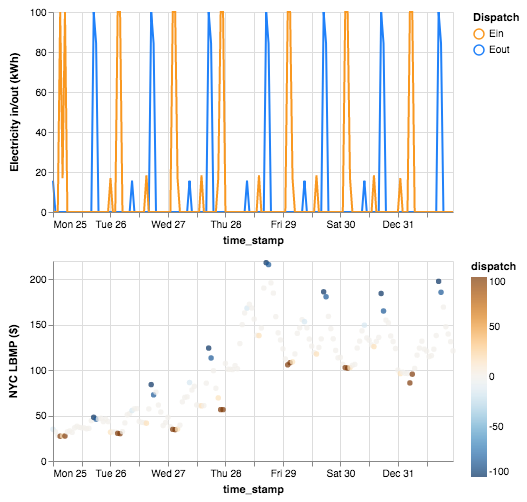

In [11]:
data = results_df.loc[(results_df.time_stamp >= '2017-01-02') &
                      (results_df.week == 52), :].copy()
data.loc[:, 'dispatch'] = data.Ein - data.Eout
dispatch_data = pd.melt(data, id_vars='time_stamp', value_vars=['Eout', 'Ein'], var_name='Dispatch')

color_scale = alt.Scale(
            domain=['Ein', 'Eout'],
            range=['#f99820', '#2081f9']
        )

dispatch = alt.Chart(dispatch_data).mark_line().encode(
    x='time_stamp:T',
    y=alt.Y('value:Q', axis=alt.Axis(title='Electricity in/out (kWh)')),
    color=alt.Color('Dispatch:N', scale=color_scale)
).properties(
    height=200
)

lbmp = alt.Chart(data).mark_circle().encode(
    x='time_stamp:T',
    y=alt.Y('lbmp:Q', axis=alt.Axis(title='NYC LBMP ($)')),
    color=alt.Color('dispatch:Q', scale=alt.Scale(scheme='blueorange')),
    tooltip='dispatch:Q'
).properties(
    height=200
)

alt.vconcat(
    dispatch,
    lbmp
)

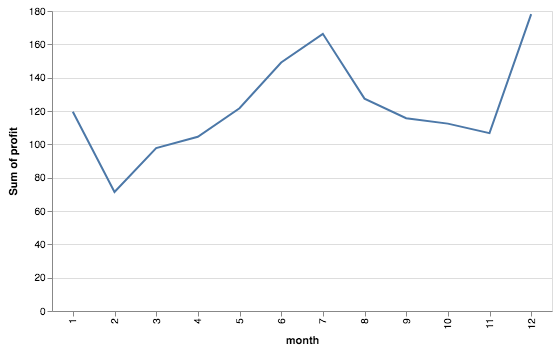

In [12]:
alt.Chart(results_df).mark_line().encode(
    x='month:O',
    y='sum(profit):Q'
).properties(
    height=300,
    width=500
)